In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.utils import resample
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import joblib # For saving the scaler and the best model

# Read in the dataset into a pandas dataframe
df = pd.read_csv("american_bankruptcy.csv")

# Drop some columns from the dataset
df = df.drop(columns = ['company_name'])
df = df.drop(columns = ['year'])

# Display the basic structure of the dataset
display(df.head(10))

,status_label,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,alive,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,alive,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.1180,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,alive,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.5928,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,alive,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.3295,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,alive,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.9071,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
5,alive,474.542,598.172,27.950,61.774,255.477,15.453,127.121,522.6794,747.848,732.230,227.159,33.824,149.676,160.025,142.450,747.848,417.486,686.074
6,alive,624.454,704.081,29.222,91.877,323.592,35.163,136.272,882.6283,897.284,978.819,318.576,62.655,193.203,187.788,183.550,897.284,556.102,805.407
7,alive,645.721,837.171,32.199,118.907,342.593,58.660,181.691,1226.1925,1061.169,1067.633,253.611,86.708,223.998,256.506,242.153,1061.169,573.390,942.262
8,alive,783.431,1080.895,39.952,168.522,435.608,75.144,202.472,747.5434,1384.919,1362.010,507.918,128.570,304.024,218.499,318.184,1384.919,776.755,1216.397
9,alive,851.312,1110.677,40.551,166.080,477.424,78.651,227.300,571.5948,1423.976,1377.511,392.984,125.529,313.299,254.418,385.851,1423.976,720.616,1257.896


In [179]:
# Data Cleaning

# Find out how many missing values are in each column in the dataset
missing_values = df.isnull().sum()
print('Missing Values per Column:')
display(missing_values)

print('\n')

# Find out how many duplicate samples are in the dataset
duplicates = df.duplicated().sum()
print('Duplicates in the Dataset:', duplicates)

Missing Values per Column:


status_label    0
X1              0
X2              0
X3              0
X4              0
X5              0
X6              0
X7              0
X8              0
X9              0
X10             0
X11             0
X12             0
X13             0
X14             0
X15             0
X16             0
X17             0
X18             0
dtype: int64



Duplicates in the Dataset: 0


In [ ]:
# Feature Engineering with Binary Encoding

# Display the class labels with their count in the dataset
print('Class Labels with Counts in the Dataset:')
display(df['status_label'].value_counts())

print('\n')

# Encoding 'alive' to 0 and 'failed' to 1
df['status_encoding'] = df['status_label'].map({'alive': 0, 'failed': 1}).astype(int)
df = df.drop(columns = ['status_label'])

print('Dataset After Binary Encoding \'alive\' to 0 and \'failed\' to 1:')
display(df.head(10))

print('\n')

# Display the encoded class labels with their count in the dataset
print('Encoded Class Labels with Counts in the Dataset:')
display(df['status_encoding'].value_counts())

Class Labels with Counts in the Dataset:


status_label
alive     73462
failed     5220
Name: count, dtype: int64



Dataset After Binary Encoding 'alive' to 0 and 'failed' to 1:


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,status_encoding
0,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302,0
1,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.1180,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888,0
2,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.5928,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514,0
3,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.3295,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592,0
4,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.9071,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467,0
5,474.542,598.172,27.950,61.774,255.477,15.453,127.121,522.6794,747.848,732.230,227.159,33.824,149.676,160.025,142.450,747.848,417.486,686.074,0
6,624.454,704.081,29.222,91.877,323.592,35.163,136.272,882.6283,897.284,978.819,318.576,62.655,193.203,187.788,183.550,897.284,556.102,805.407,0
7,645.721,837.171,32.199,118.907,342.593,58.660,181.691,1226.1925,1061.169,1067.633,253.611,86.708,223.998,256.506,242.153,1061.169,573.390,942.262,0
8,783.431,1080.895,39.952,168.522,435.608,75.144,202.472,747.5434,1384.919,1362.010,507.918,128.570,304.024,218.499,318.184,1384.919,776.755,1216.397,0
9,851.312,1110.677,40.551,166.080,477.424,78.651,227.300,571.5948,1423.976,1377.511,392.984,125.529,313.299,254.418,385.851,1423.976,720.616,1257.896,0




Encoded Class Labels with Counts in the Dataset:


status_encoding
0    73462
1     5220
Name: count, dtype: int64

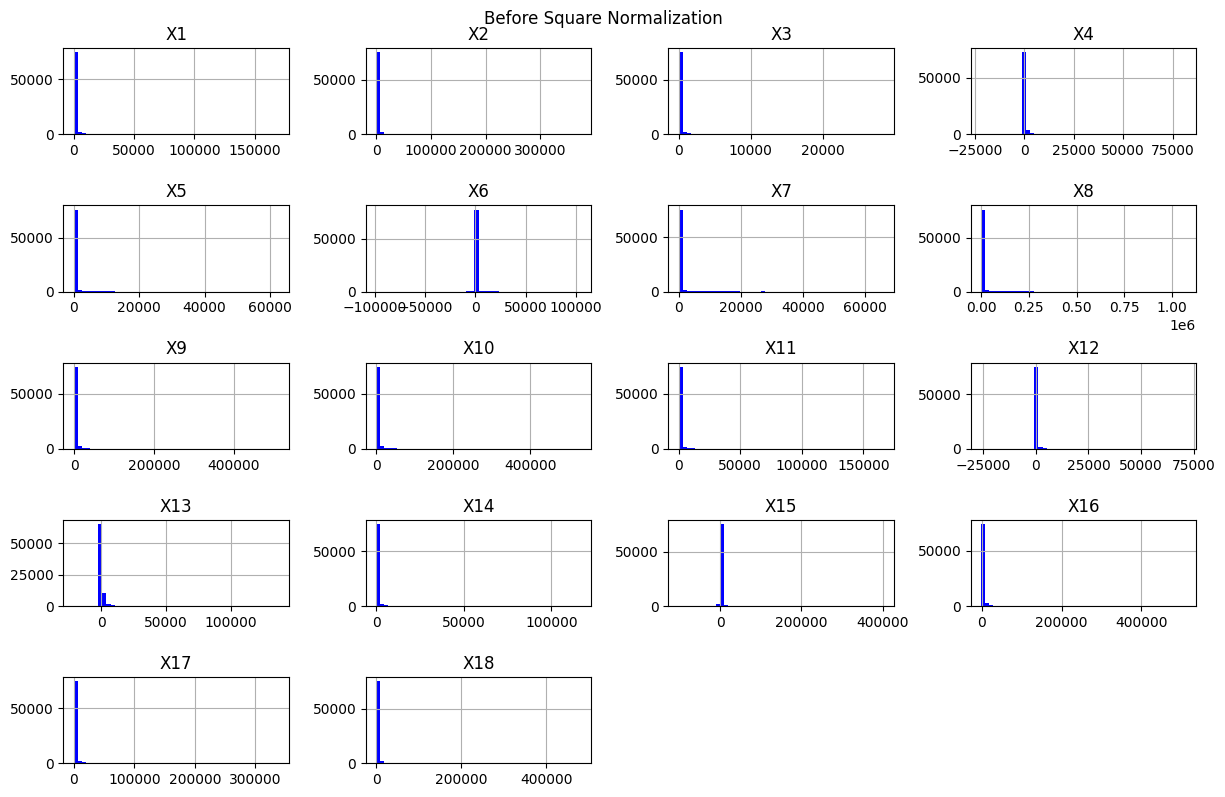

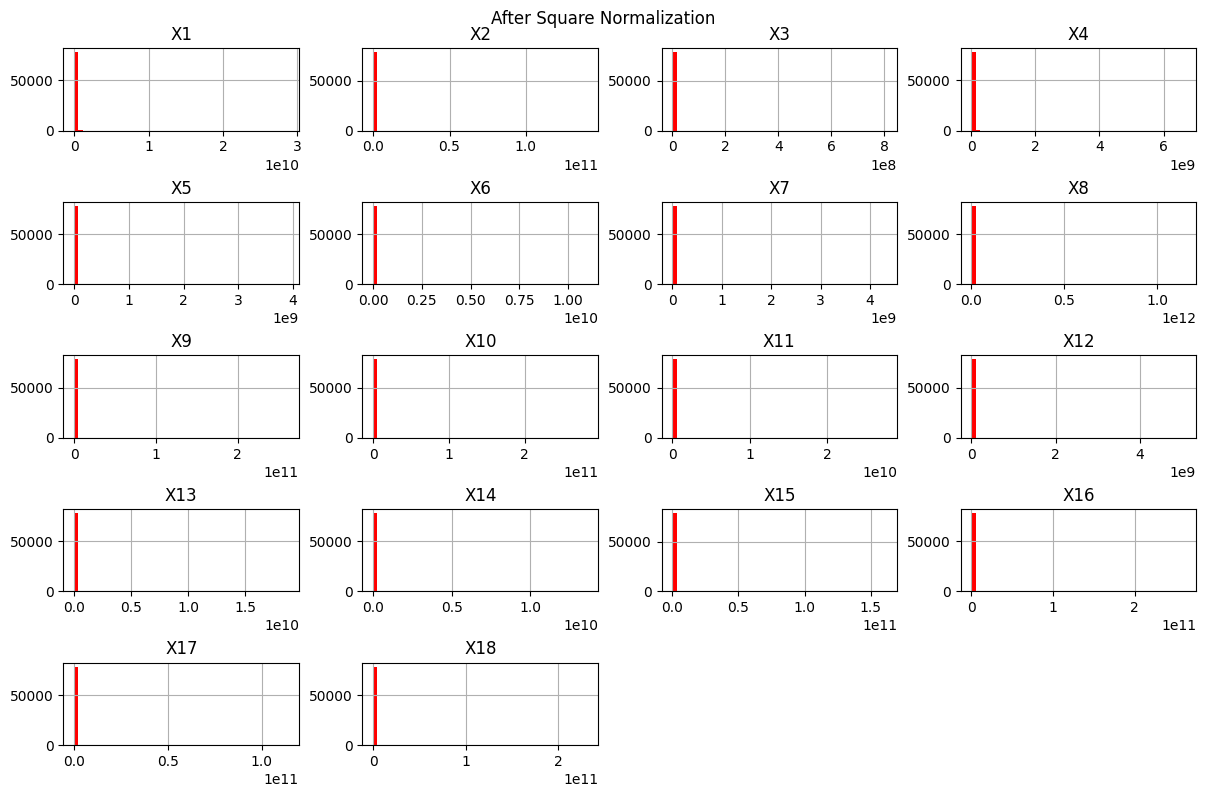

In [4]:
# Square Normalization

df_square = df.copy()

columns_to_normalize = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6',
                       'X7', 'X8', 'X9', 'X10', 'X11', 'X12',
                       'X13', 'X14', 'X15', 'X16', 'X17', 'X18']

# Visualize the data before applying the transformation
df_square[columns_to_normalize].hist(bins=50, figsize=(12, 8), color='blue')
plt.suptitle('Before Square Normalization')
plt.tight_layout(pad=0.5)
plt.show()

# Apply the square transformation
for column in columns_to_normalize:
    df_square[column] = df_square[column].apply(lambda x: x**2)

# Visualize the data after the transformation
df_square[columns_to_normalize].hist(bins=50, figsize=(12, 8), color='red')
plt.suptitle('After Square Normalization')
plt.tight_layout(pad=0.5)
plt.show()

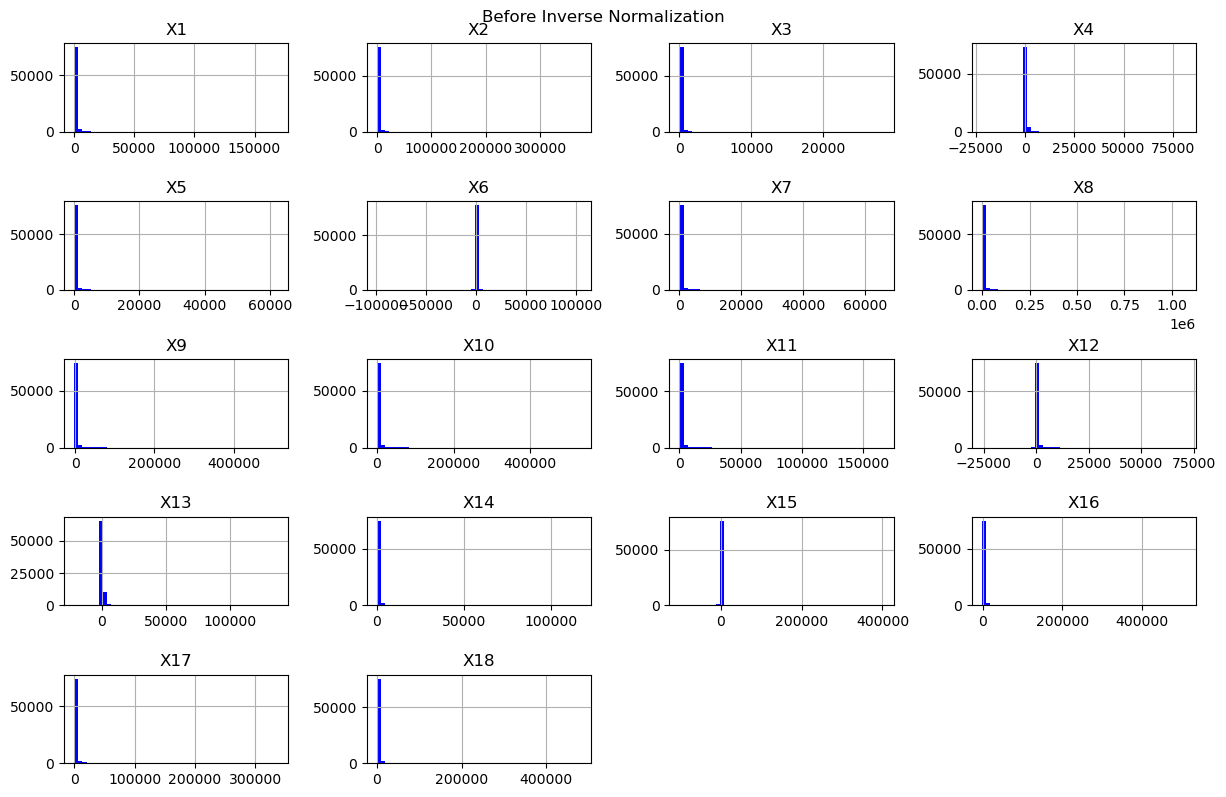

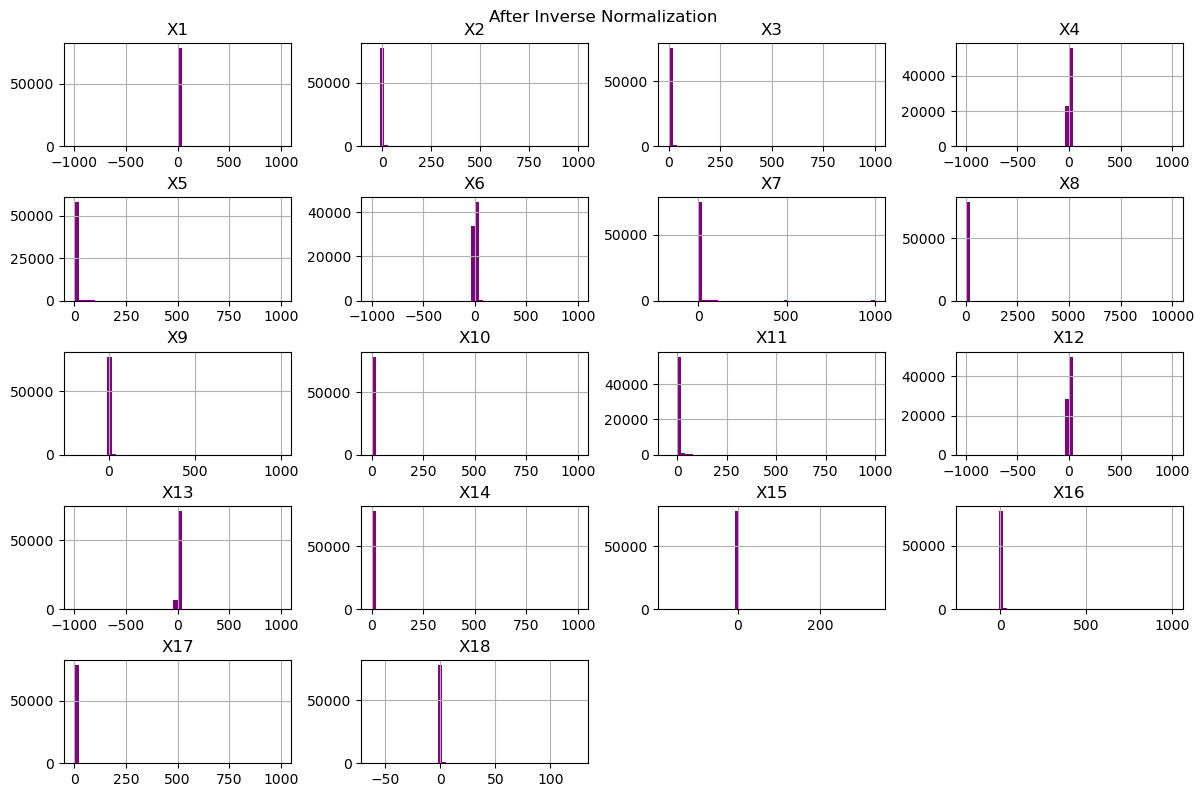

In [ ]:
# Inverse Normalization

df_inverse = df.copy()

columns_to_normalize = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6',
                       'X7', 'X8', 'X9', 'X10', 'X11', 'X12',
                       'X13', 'X14', 'X15', 'X16', 'X17', 'X18']

# Visualize the data before the transformation
df_inverse[columns_to_normalize].hist(bins=50, figsize=(12, 8), color='blue')
plt.suptitle('Before Inverse Normalization')
plt.tight_layout(pad=0.5)
plt.show()

# Apply the inverse transformation
for column in columns_to_normalize:
    df_inverse[column] = df_inverse[column].apply(lambda x: 1/x if x != 0 else np.nan)

# Visualize the data after the transformation
df_inverse[columns_to_normalize].hist(bins=50, figsize=(12, 8), color='purple')
plt.suptitle('After Inverse Normalization')
plt.tight_layout(pad=0.5)
plt.show()

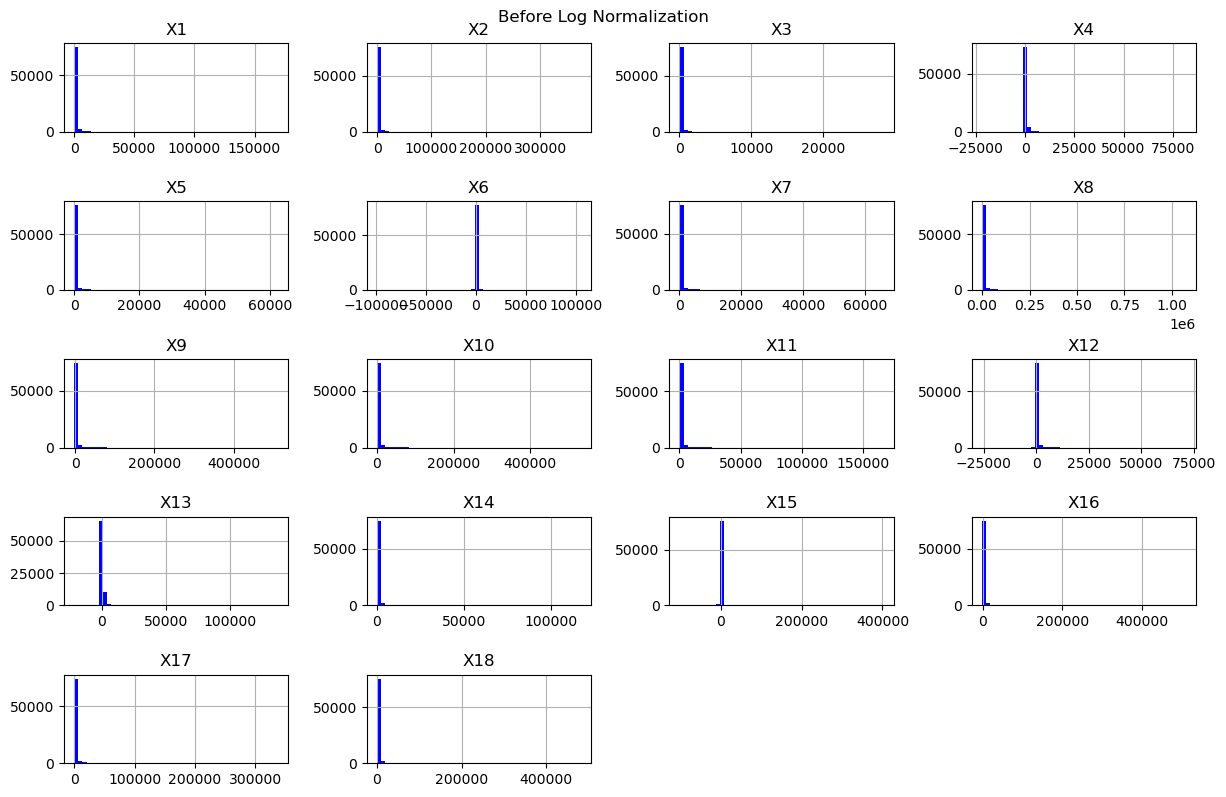

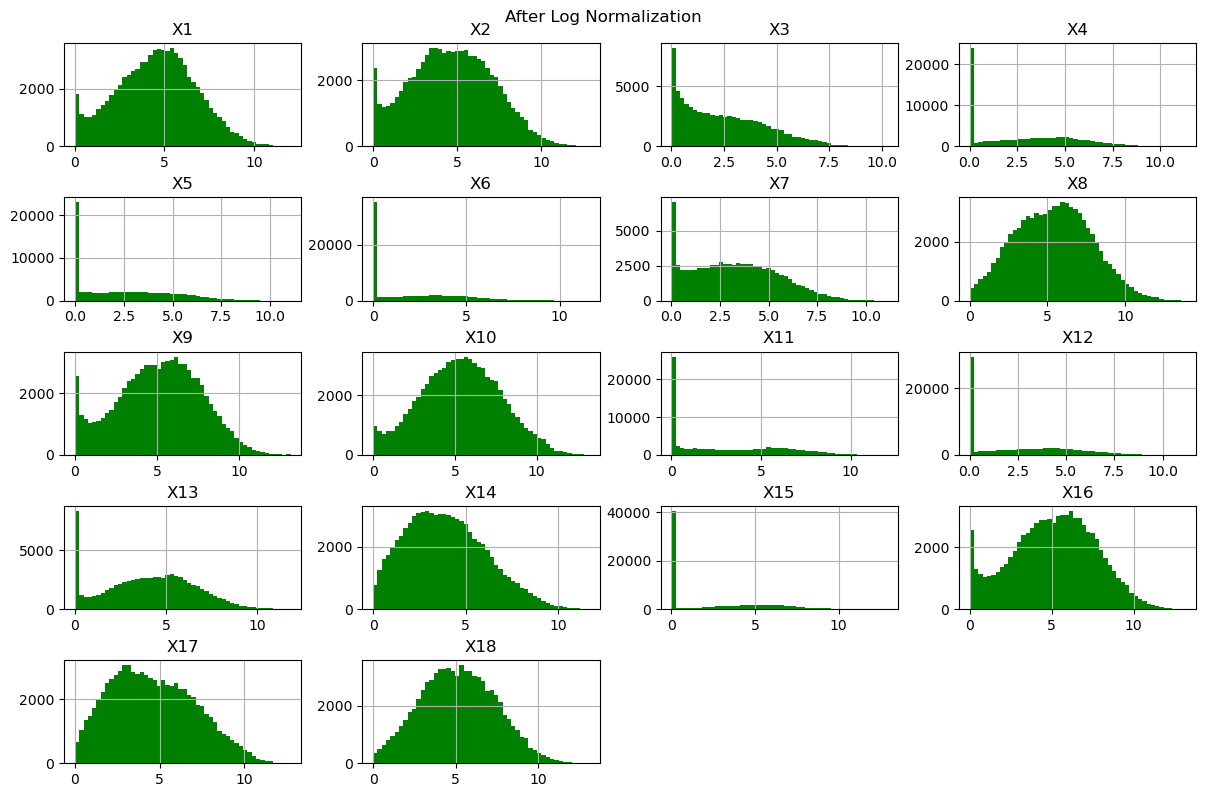

In [183]:
# Log Normalization (Works the Best Out of all the Normalization Techniques Used)

df_log = df.copy()

columns_to_normalize = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6',
                       'X7', 'X8', 'X9', 'X10', 'X11', 'X12',
                       'X13', 'X14', 'X15', 'X16', 'X17', 'X18']

# Visualize the data before applying the transformation
df_log[columns_to_normalize].hist(bins=50, figsize=(12, 8), color='blue')
plt.suptitle('Before Log Normalization')
plt.tight_layout(pad=0.5)
plt.show()

# Apply the log transformation
for column in columns_to_normalize:
    df_log[column] = df_log[column].apply(lambda x: np.log1p(x) if x > 0 else 0)

# Replace any remaining inf values with NaN
df_log.replace([np.inf, -np.inf], np.nan, inplace=True)

# Visualize the data after the transformation
df_log[columns_to_normalize].hist(bins=50, figsize=(12, 8), color='green')
plt.suptitle('After Log Normalization')
plt.tight_layout(pad=0.5)
plt.show()

# df is now the original dataframe with log-transformed values
df = df_log

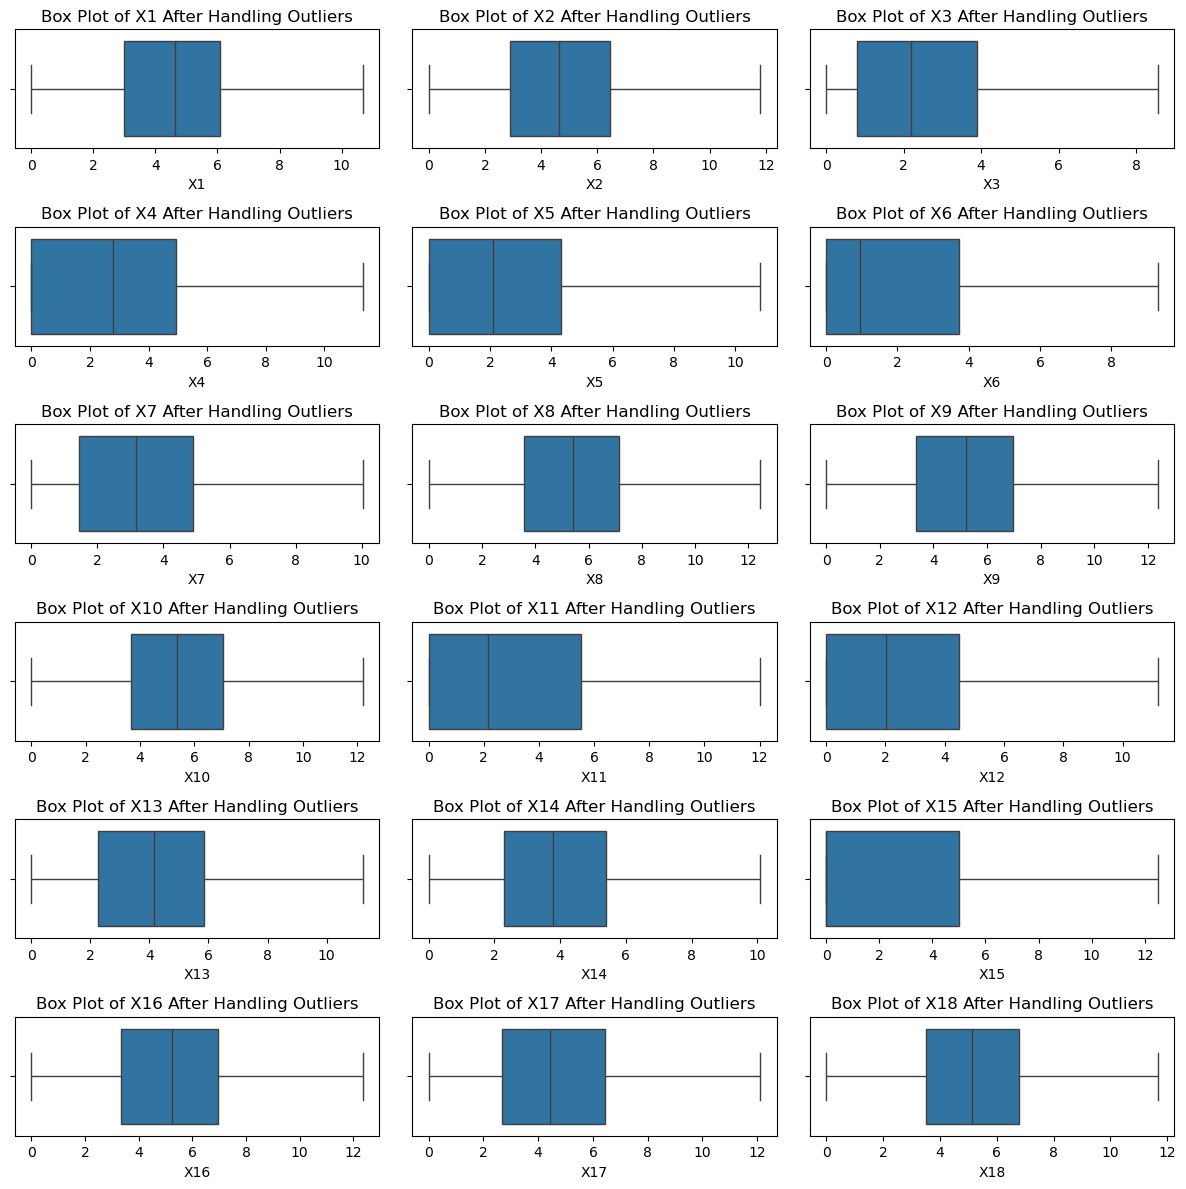

In [185]:
# Outlier Detection

features_to_plot = df.columns[df.columns != 'status_encoding']

for feature in features_to_plot:
    Q1 = df[feature].quantile(0.25)
    Q2 = df[feature].quantile(0.50)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR
    df[feature] = df[feature].clip(lower=lowerBound, upper=upperBound)

num_features = len(features_to_plot)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

plt.figure(figsize=(12, 2 * num_rows))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature} After Handling Outliers')
plt.tight_layout()
plt.show()

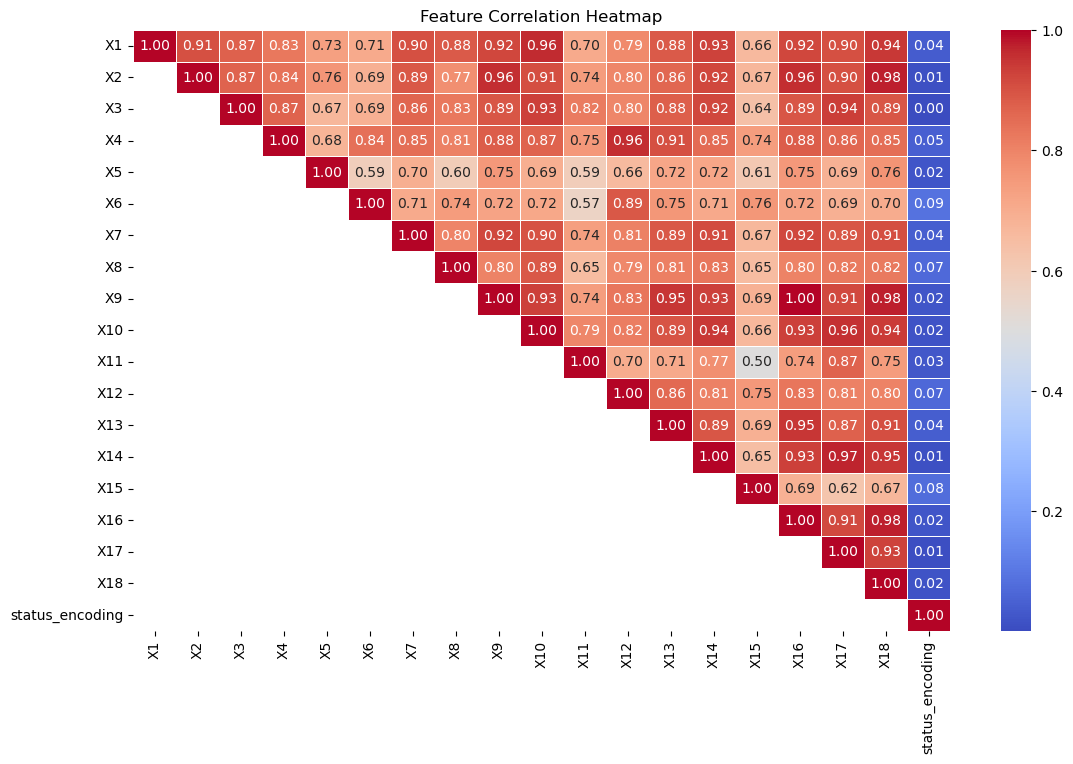

Dropped columns: ['X2', 'X3', 'X4', 'X7', 'X8', 'X9', 'X10', 'X12', 'X13', 'X14', 'X16', 'X17', 'X18']


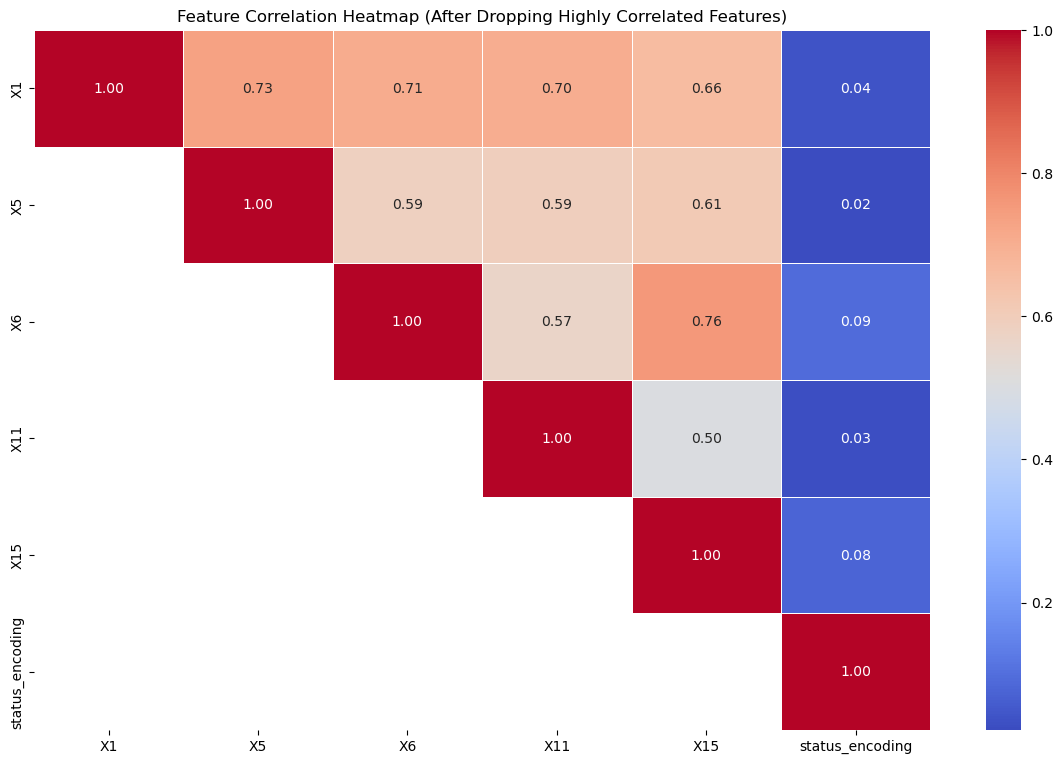

In [187]:
# Feature Selection Heatmap (The Best Method)

# Calculate the correlation matrix
correlation_matrix = df.corr().abs()

# Create a mask for the lower triangle to avoid the mirror values
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Invert the mask to keep the upper triangle
mask = np.invert(mask)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout(pad=2.0)
plt.show()

# Select upper triangle of the correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find the index of feature columns with a correlation greater than the threshold
threshold = 0.85
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop those features
df_reduced = df.drop(columns=to_drop)

print(f"Dropped columns: {to_drop}")

# Recalculate the correlation matrix after dropping the features
correlation_matrix_reduced = df_reduced.corr().abs()

# Create a mask for the lower triangle to avoid the mirror values
mask_reduced = np.triu(np.ones_like(correlation_matrix_reduced, dtype=bool))

# Invert the mask to keep the upper triangle
mask_reduced = np.invert(mask_reduced)

# Create a heatmap with the updated correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_reduced, mask=mask_reduced, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap (After Dropping Highly Correlated Features)')
plt.tight_layout(pad=2.0)
plt.show()

Dataset After Z-Score Scaling:


,X1,X5,X6,X11,X15,status_encoding
0,0.749119,1.394333,0.730806,-0.982470,1.150879,0
1,1.478968,1.699760,1.804455,2.104993,-0.840255,0
2,0.416184,1.104210,0.575363,-1.008402,0.744977,0
3,1.715795,2.266583,1.917170,1.912754,2.188324,0
4,-0.247070,-0.132677,0.094677,0.346547,0.105886,0
5,0.749493,0.211465,1.518772,1.450642,1.571579,0
6,0.543668,0.095328,-0.861097,1.318644,0.620193,0
7,0.749814,-1.060516,-0.861097,-1.008402,-0.840255,0
8,-0.145014,-0.808775,0.083053,-1.008402,-0.840255,0
9,-0.235915,-1.060516,-0.861097,-1.006362,-0.840255,0


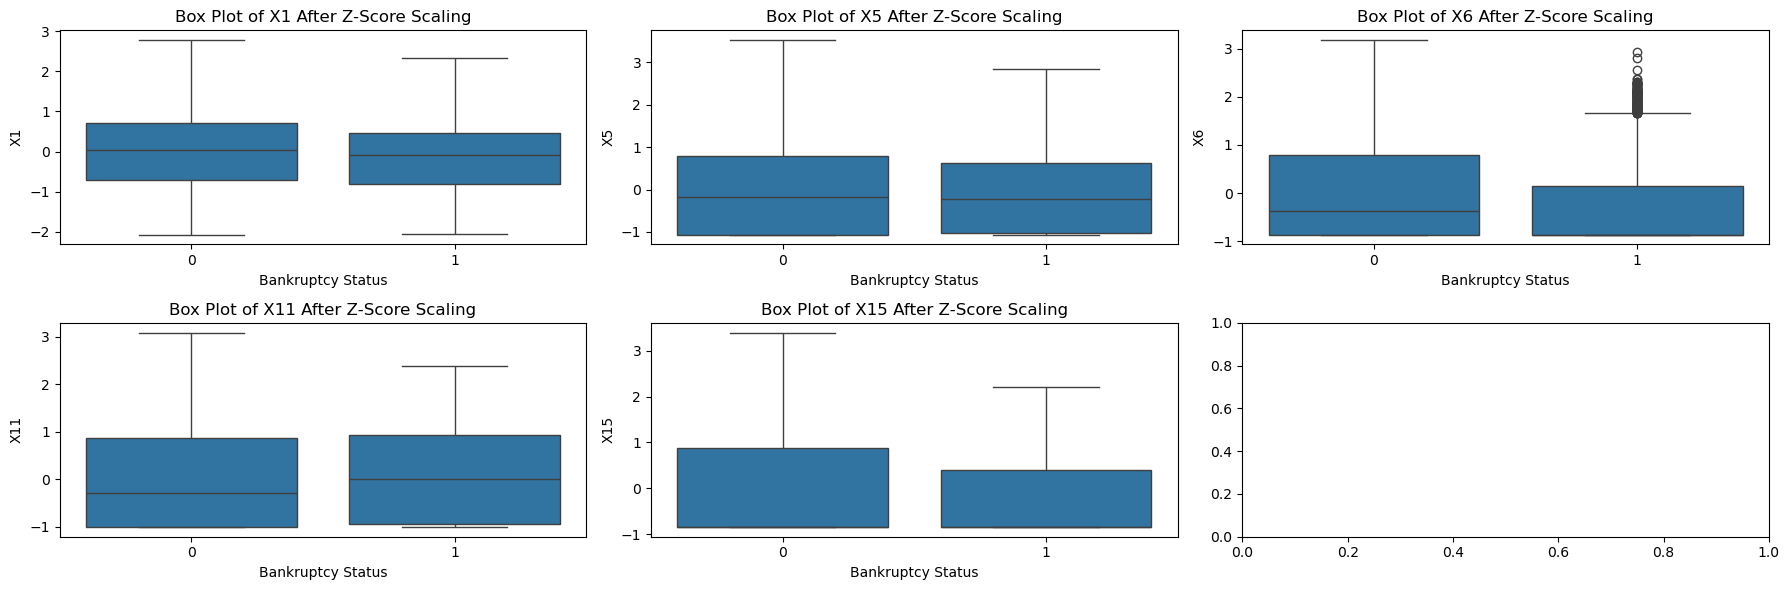

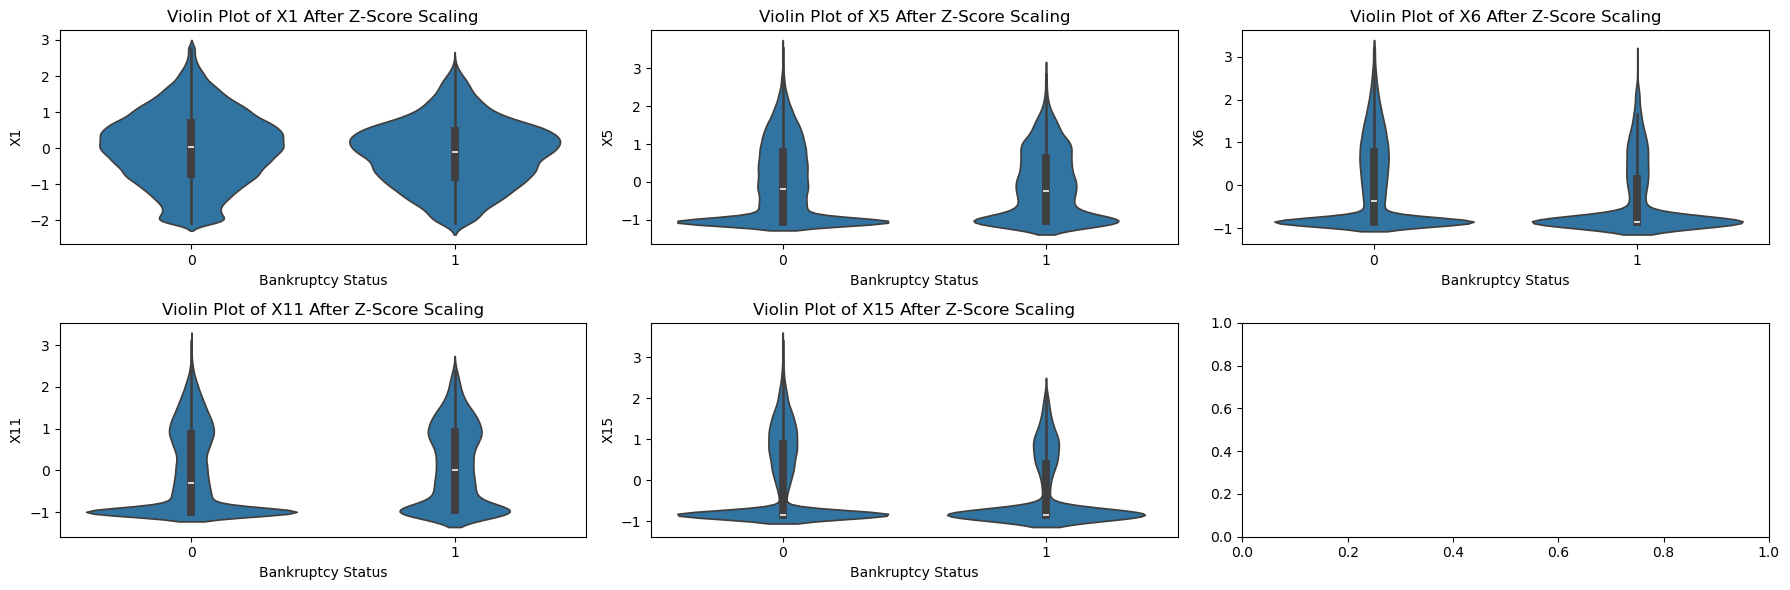

In [189]:
# Data Scaling/Standardization with Z-Score Scaling

scaler = StandardScaler()

X = df_reduced.iloc[:, :-1]
y = df_reduced['status_encoding']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.20, shuffle=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns=X.columns), pd.DataFrame(y_train.reset_index(drop=True), columns =['status_encoding'])], axis=1)
test_scaled = pd.concat([pd.DataFrame(X_test_scaled, columns=X.columns), pd.DataFrame(y_test.reset_index(drop=True), columns =['status_encoding'])], axis=1)
df_scaled = pd.concat([train_scaled, test_scaled], axis=0)

print('Dataset After Z-Score Scaling:')
display(df_scaled.head(10))

print('\n')

diagram_columns = 3
attribute_columns = df_scaled.shape[1] - 1
diagram_rows = math.ceil(attribute_columns / diagram_columns)

row_index = 0
column_index = 0
fig, axes = plt.subplots(diagram_rows, diagram_columns, figsize=(18, diagram_rows * 3))
for column in df_scaled.columns[:-1]:
    sns.boxplot(x='status_encoding', y=column, data=df_scaled, ax=axes[row_index, column_index])
    axes[row_index, column_index].set_title(f'Box Plot of {column} After Z-Score Scaling')
    axes[row_index, column_index].set_xlabel('Bankruptcy Status')
    axes[row_index, column_index].set_ylabel(f'{column}')
    column_index += 1
    if column_index == diagram_columns:
        row_index += 1
        column_index = 0
plt.tight_layout()
plt.show()

print('\n')

row_index = 0
column_index = 0
fig, axes = plt.subplots(diagram_rows, diagram_columns, figsize=(18, diagram_rows * 3))
for column in df_scaled.columns[:-1]:
    sns.violinplot(x='status_encoding', y=column, data=df_scaled, ax=axes[row_index, column_index])
    axes[row_index, column_index].set_title(f'Violin Plot of {column} After Z-Score Scaling')
    axes[row_index, column_index].set_xlabel('Bankruptcy Status')
    axes[row_index, column_index].set_ylabel(f'{column}')
    column_index += 1
    if column_index == diagram_columns:
        row_index += 1
        column_index = 0
plt.tight_layout()
plt.show()

In [190]:
# Applying SMOTE for Oversampling the Minority Class

# Applying SMOTE to balance the training data
smote = SMOTE(random_state=21)

# Balancing the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before Oversampling the Majority Class:")
print(pd.Series(y_train).value_counts())

print('\n')

print("After Oversampling the Majority Class:")
print(pd.Series(y_train_smote).value_counts())

X_train_balanced_smote = X_train_smote.to_numpy()
y_train_balanced_smote = y_train_smote.to_numpy()

Before Oversampling the Majority Class:
status_encoding
0    58742
1     4203
Name: count, dtype: int64


After Oversampling the Majority Class:
status_encoding
0    58742
1    58742
Name: count, dtype: int64


In [193]:
# Employing Hybrid Sampling with SMOTEENN

smoteenn = SMOTEENN(random_state=21)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

print("Before Hybrid-sampling the Majority Class:")
print(pd.Series(y_train).value_counts())

print('\n')

print("After Hybrid-Sampling the Majority Class:")
print(pd.Series(y_train_smoteenn).value_counts())

X_train_balanced_smoteenn = X_train_smoteenn.to_numpy()
y_train_balanced_smoteenn = y_train_smoteenn.to_numpy()

Before Hybrid-sampling the Majority Class:
status_encoding
0    58742
1     4203
Name: count, dtype: int64


After Hybrid-Sampling the Majority Class:
status_encoding
1    48876
0    40693
Name: count, dtype: int64


In [195]:
# Undersampling the Majority Class (Works the Best for Logistic Regression and Random Forest)

df_temp = train_scaled.copy()

df_class_0 = df_temp[df_temp['status_encoding'] == 0]
df_class_1 = df_temp[df_temp['status_encoding'] == 1]

df_class_0_undersampled = resample(df_class_0, replace=False, n_samples=len(df_class_1), random_state=21)

df_balanced = pd.concat([df_class_0_undersampled, df_class_1], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=21).reset_index(drop=True)

print("Before Undersampling the Majority class:")
print(pd.Series(y_train).value_counts())

print('\n')

print("After Undersampling the Majority Class:")
print(df_balanced['status_encoding'].value_counts())

X_train_balanced_under = df_balanced.drop(columns=['status_encoding']).to_numpy()
y_train_balanced_under = df_balanced['status_encoding'].to_numpy()

Before Undersampling the Majority class:
status_encoding
0    58742
1     4203
Name: count, dtype: int64


After Undersampling the Majority Class:
status_encoding
1    4203
0    4203
Name: count, dtype: int64


Random Forest Classifier Results:

Accuracy: 0.6482175764122768


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.77     14720
           1       0.12      0.69      0.20      1017

    accuracy                           0.65     15737
   macro avg       0.54      0.67      0.49     15737
weighted avg       0.91      0.65      0.74     15737



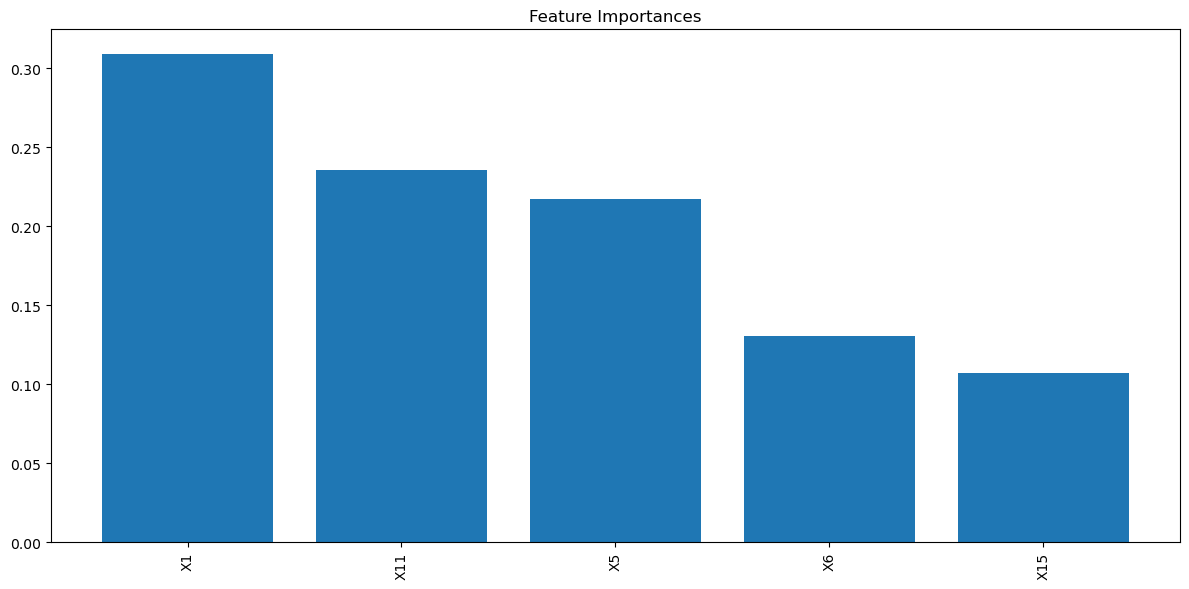

In [ ]:
# Applying the Random Forest Model

random_forest = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=None)

# Train the classifier
random_forest.fit(X_train_balanced_under, y_train_balanced_under)

y_pred = random_forest.predict(X_test_scaled)

print("Random Forest Classifier Results:\n")

print("Accuracy:", accuracy_score(y_test, y_pred))

print('\n')

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualization
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [197]:
# Applying the Logistic Regression Model

param_grid = {
    'penalty': ['l1', 'l2'], # L1 and L2 regularization
    'C': [0.01, 0.1, 1, 10, 100], # C is 1 / lambda (i.e. the inverse of the regularization parameter)
    'max_iter': [100, 200, 300, 400] # The maximum number of iterations, which is similar, but not analogous to epochs
}

model = LogisticRegression(solver='liblinear')

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train_balanced_under, y_train_balanced_under)

best_params = grid_result.best_params_
best_score = grid_result.best_score_

print('The Best Model\'s Hyper-Parameters:', best_params)
print('Accuracy of the Best Model: {:.2f}%'.format(best_score * 100))

The Best Model's Hyper-Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}
Accuracy of the Best Model: 60.87%


In [ ]:
lgr_model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], solver='liblinear', max_iter=best_params['max_iter'])
history = lgr_model.fit(X_train_balanced_under, y_train_balanced_under) # Can use history for plotting useful graphs
y_pred = lgr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy of the Best Model on the Testing Data with Default Threshold: {:.2f}%'.format(accuracy * 100))

Accuracy of the Best Model on the Testing Data with Default Threshold: 57.35%


In [ ]:
y_pred_proba = lgr_model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.5
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.96      0.57      0.71     14720
           1       0.09      0.64      0.16      1017

    accuracy                           0.57     15737
   macro avg       0.53      0.60      0.44     15737
weighted avg       0.90      0.57      0.68     15737



"\n\naccuracy = accuracy_score(y_test, y_pred_adjusted)\nprint('Accuracy of the Best Model on the Testing Data with Threshold {:.2f}: {:.2f}%'.format(threshold, accuracy * 100))\n\nprecision = precision_score(y_test, y_pred_adjusted)\nprint('Precision of the Best Model on the Testing Data with Threshold {:.2f}: {:.2f}%'.format(threshold, precision * 100))\n\nrecall = recall_score(y_test, y_pred_adjusted)\nprint('Recall of the Best Model on the Testing Data with Threshold {:.2f}: {:.2f}%'.format(threshold, recall * 100))\n\nf1 = f1_score(y_test, y_pred_adjusted)\nprint('F1-Score of the Best Model on the Testing Data with Threshold {:.2f}: {:.2f}%'.format(threshold, f1 * 100))\n\nprint(f'Accuracy of the Best Model With the Threshold {threshold}: {accuracy * 100:.2f}%')\n\n"

Logistic Regression Result Plots



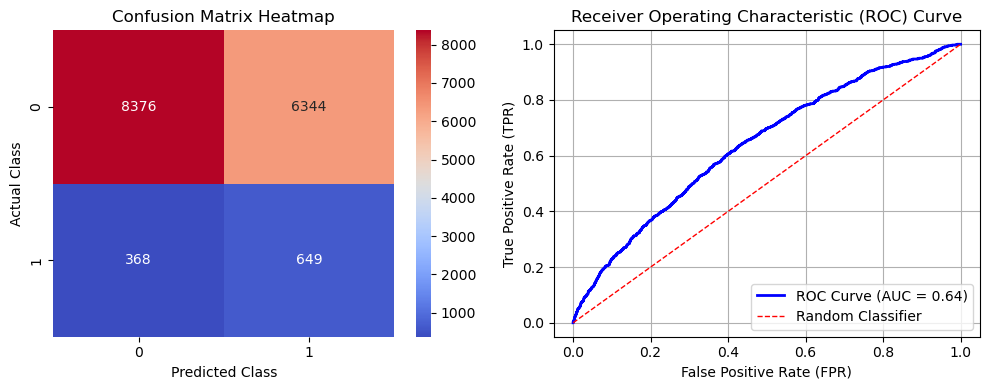

In [207]:
# Plot Results

print('Logistic Regression Result Plots\n')

cm = confusion_matrix(y_test, y_pred_adjusted)

plt.figure(figsize=(10, 4))

# Visualize correlation matrix using heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.show()

# Generate model predictions and probabilities
y_pred_proba = lgr_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Compute FPR, TPR, and thresholds for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier', linewidth=1)  # Diagonal for random classifier
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# XGBoost

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the classifier with logloss
model = XGBClassifier(eval_metric='logloss')

# Set up the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the to the training data
grid_result = grid.fit(X_train_balanced_smoteenn, y_train_balanced_smoteenn)

# Extract the best hyperparameters
best_params = grid_result.best_params_
best_score = grid_result.best_score_

# Print the results
print('The Best Model\'s Hyper-Parameters:', best_params)
print('Accuracy of the Best Model: {:.2f}%'.format(best_score * 100))

The Best Model's Hyper-Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Accuracy of the Best Model: 89.26%


'\n\nmodel = XGBClassifier()\nmodel.fit(X_train_balanced_smoteenn, y_train_balanced_smoteenn)\ny_pred = model.predict(X_test_scaled)\nprint("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred) * 100.0))\nprint(confusion_matrix(y_test, y_pred))\n\n'

In [ ]:
xgb_model = XGBClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], eval_metric='logloss',
                          learning_rate=best_params['learning_rate'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'],
                          gamma=best_params['gamma'])
history = xgb_model.fit(X_train_balanced_smoteenn, y_train_balanced_smoteenn) # Can use history for plotting useful graphs
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy of the Best Model on the Testing Data: {:.2f}%'.format(accuracy * 100))

print('\n')

print(classification_report(y_test, y_pred))

Accuracy of the Best Model on the Testing Data: 87.93%


              precision    recall  f1-score   support

           0       0.94      0.93      0.94     14720
           1       0.09      0.10      0.09      1017

    accuracy                           0.88     15737
   macro avg       0.51      0.51      0.51     15737
weighted avg       0.88      0.88      0.88     15737



XGBoost Result Plots



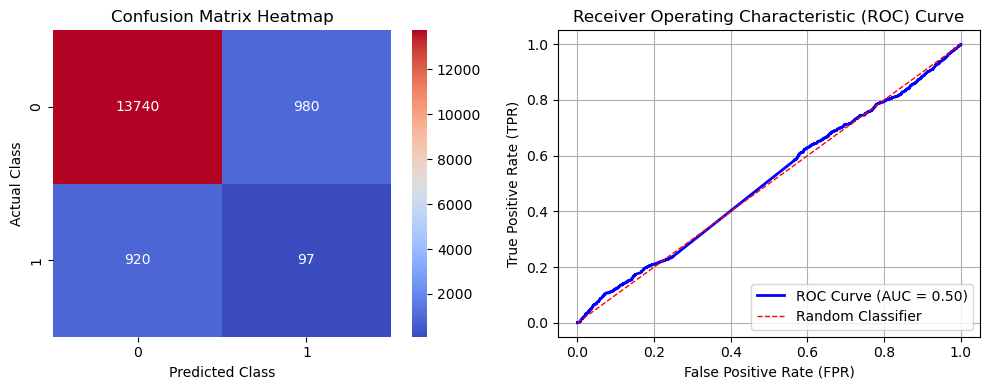

In [167]:
print('XGBoost Result Plots\n')

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 4))

# Visualize correlation matrix using heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.show()

# Generate model predictions and probabilities
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Compute FPR, TPR, and thresholds for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier', linewidth=1)  # Diagonal for random classifier
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(X_train.mean(), 'col_averages.pkl') # Save the column averages for data imputation
joblib.dump(scaler, 'scaler.pkl') # Save the scaler
joblib.dump(random_forest, 'best_model.pkl') # Save the best model